In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [3]:
# Load the dataset
url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
                "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
                "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
                "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
                "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]

df = pd.read_csv(url, names=column_names)

df.info()
df.describe()


  duration protocol_type service  flag  src_bytes  dst_bytes  land  \
0      tcp          http      SF   181       5450          0     0   
0      tcp          http      SF   239        486          0     0   
0      tcp          http      SF   235       1337          0     0   
0      tcp          http      SF   219       1337          0     0   
0      tcp          http      SF   217       2032          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...               9                 1.0   
0               0       0    0  ...              19                 1.0   
0               0       0    0  ...              29                 1.0   
0               0       0    0  ...              39                 1.0   
0               0       0    0  ...              49                 1.0   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     0.0                    0.11   
0                     

In [4]:
# Detect categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Features:", categorical_features)

# Detect numerical features
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("Numerical Features:", numerical_features)


Categorical Features: ['duration', 'protocol_type', 'service', 'dst_host_srv_rerror_rate']
Numerical Features: ['flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate']


In [5]:
# Calculate the correlation matrix for numerical features
corr_matrix = df[numerical_features].corr()

# Set a threshold for high correlation
threshold = 0.8

# Identify highly correlated features
high_corr = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.0)].stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']
print("Highly Correlated Features:\n", high_corr)


Highly Correlated Features:
                        Feature1                     Feature2  Correlation
0                        urgent                is_host_login     0.843572
1                     logged_in                 su_attempted     0.993828
2                  su_attempted                    logged_in     0.993828
3                 is_host_login                       urgent     0.843572
4                is_guest_login                        count     0.943667
5                is_guest_login       dst_host_diff_srv_rate     0.860579
6                         count               is_guest_login     0.943667
7                         count       dst_host_diff_srv_rate     0.944926
8                     srv_count                  serror_rate     0.998362
9                     srv_count  dst_host_srv_diff_host_rate     0.998673
10                    srv_count         dst_host_serror_rate     0.997849
11                  serror_rate                    srv_count     0.998362
12       

In [6]:
# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(df)

In [7]:
# Convert the preprocessed data to a dense format
X_dense = X_preprocessed.toarray()

# Subset the data for quicker computation
subset_size = 10000
X_subset = X_dense[:subset_size]
df_subset = df.iloc[:subset_size].copy()  

# Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)


In [8]:
# Clustering
kmeans_pca = KMeans(n_clusters=2, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca)

kmeans_tsne = KMeans(n_clusters=2, random_state=42)
labels_tsne = kmeans_tsne.fit_predict(X_tsne)

# Silhouette scores
silhouette_avg_pca = silhouette_score(X_pca, labels_pca)
silhouette_avg_tsne = silhouette_score(X_tsne, labels_tsne)

print(f'Silhouette Score (PCA): {silhouette_avg_pca}')
print(f'Silhouette Score (t-SNE): {silhouette_avg_tsne}')


Silhouette Score (PCA): 0.814925198269983
Silhouette Score (t-SNE): 0.36238691210746765


In [12]:
# Add cluster labels to the subset dataframe
df_subset['Cluster_PCA'] = labels_pca
df_subset['Cluster_TSNE'] = labels_tsne

# Determine which clusters might be anomalies
cluster_sizes_pca = pd.Series(labels_pca).value_counts()
anomaly_clusters_pca = cluster_sizes_pca[cluster_sizes_pca == cluster_sizes_pca.min()].index

cluster_sizes_tsne = pd.Series(labels_tsne).value_counts()
anomaly_clusters_tsne = cluster_sizes_tsne[cluster_sizes_tsne == cluster_sizes_tsne.min()].index

# Vectorized anomaly labeling
df_subset['Is_Anomaly_PCA'] = np.where(df_subset['Cluster_PCA'].isin(anomaly_clusters_pca), 1, 0)
df_subset['Is_Anomaly_TSNE'] = np.where(df_subset['Cluster_TSNE'].isin(anomaly_clusters_tsne), 1, 0)

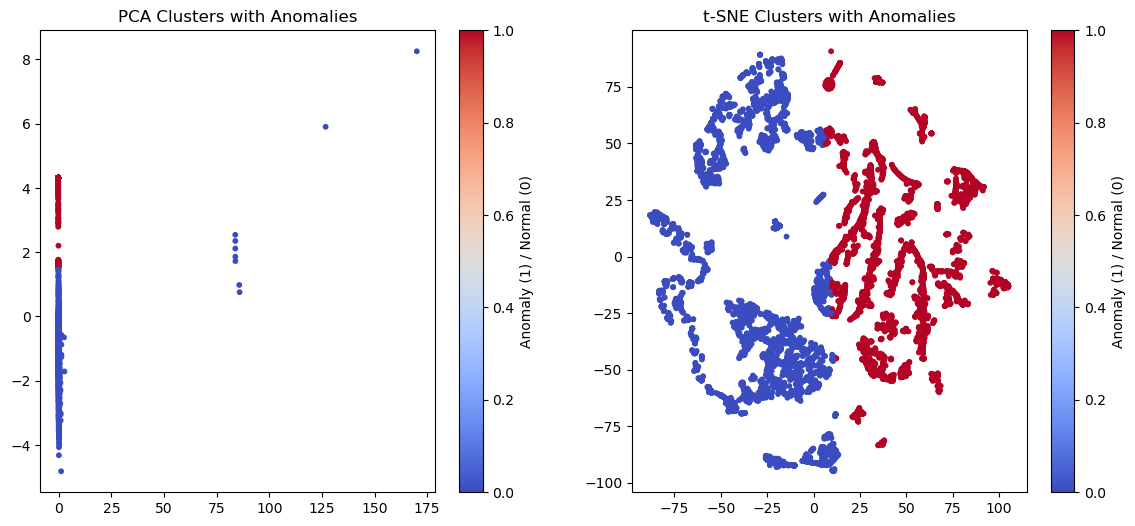

In [13]:
# Visualization
plt.figure(figsize=(14, 6))

# PCA Clusters with anomaly labeling
plt.subplot(1, 2, 1)
scatter_pca = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_subset['Is_Anomaly_PCA'], cmap='coolwarm', s=10)
plt.title('PCA Clusters with Anomalies')
plt.colorbar(scatter_pca, label='Anomaly (1) / Normal (0)')

# t-SNE Clusters with anomaly labeling
plt.subplot(1, 2, 2)
scatter_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_subset['Is_Anomaly_TSNE'], cmap='coolwarm', s=10)
plt.title('t-SNE Clusters with Anomalies')
plt.colorbar(scatter_tsne, label='Anomaly (1) / Normal (0)')

plt.show()

In [ ]:
# This block of code adds our cluster findings to the original datase (in case we want to build use the data frame to build a predictive model using a supervised method)

# Due to computational limitations, I have only ran the clustering algorithm on a subset of the original dataset. We can either drop the rows with "Na" label values, or rerun the clustering model (on the entire dataset).

# Initialize the anomaly columns in the full dataset
df['Is_Anomaly_PCA'] = pd.NA
df['Is_Anomaly_TSNE'] = pd.NA

# Map the subset anomaly labels to the full dataset
df.loc[df_subset.index, 'Is_Anomaly_PCA'] = df_subset['Is_Anomaly_PCA']
df.loc[df_subset.index, 'Is_Anomaly_TSNE'] = df_subset['Is_Anomaly_TSNE']

# Confirm that labels were added
print(df[['Cluster_PCA', 'Cluster_TSNE', 'Is_Anomaly_PCA', 'Is_Anomaly_TSNE']].head())
